# QUIMB save boundary operators
Created 04/07/2024

Objectives:
* Use QUIMB to extract boundary operators on the ED states.

# Package imports

In [1]:
import sys

In [9]:
sys.path.append("../")

In [3]:
from itertools import chain
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [5]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [10]:
DATA_DIR = r"../data/transverse_cluster_14_site_ed"

In [19]:
def split_full_state_legs(full_state_psi):
    dim = full_state_psi.shape

    num_legs = int(np.log2(dim[0]))
    new_labels = [f'p{i}' for i in range(num_legs)]

    full_state_psi.iset_leg_labels(['(' + '.'.join(new_labels) + ')'])
    full_state_psi = full_state_psi.split_legs([0])
    return full_state_psi

In [11]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [12]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [13]:
psi_dict = dict()

In [34]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )
    #psi = split_full_state_legs(psi)
    
    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

In [21]:
psi_dict[0]

<npc.Array shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2) labels=['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13']>

In [ ]:
psi_arrays = list()
psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, mps_psi.L-1):
    psi_arrays.append(mps_psi.get_B(i).to_ndarray())
psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())

q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(psi_arrays, shape='lpr')
)

In [35]:
test_tenpy_psi = psi_dict[0]

In [36]:
test_tenpy_psi.to_ndarray().shape

(16384,)

In [28]:
np.log2(16384)

14.0

In [32]:
help(qu.infer_size)

Help on function infer_size in module quimb.core:

infer_size(p, base=2)
    Infer the size, i.e. number of 'sites' in a state.
    
    Parameters
    ----------
    p : vector or operator
        An array representing a state with a shape attribute.
    base : int, optional
        Size of the individual states that ``p`` is composed of, e.g. this
        defauts 2 for qubits.
    
    Returns
    -------
    int
        Number of composite systems.
    
    Examples
    --------
    >>> infer_size(singlet() & singlet())
    4
    
    >>> infersize(rand_rho(5**3), base=5)
    3



In [37]:
qu.infer_size(test_tenpy_psi.to_ndarray())

14

In [38]:
test_quimb_psi = qtn.Dense1D(
    test_tenpy_psi.to_ndarray(),
    phys_dim=2
)

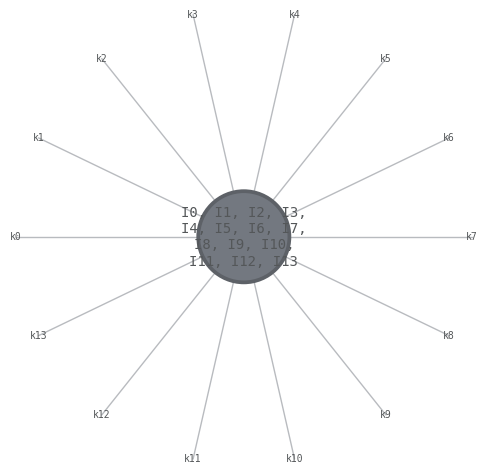

In [40]:
test_quimb_psi.draw()

# Definitions

In [42]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])

In [43]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [44]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [84]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    """
    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )
    """

    tnc = tn.contract()

    return tnc

In [46]:
def initialize_mpo(left_most_symmetry_site, num_symmetry_sites,
                   num_boundary_sites, bond_dimension, phys_dim=2):
    # Kind of hard coding the physical dimensions.
    ml = qtn.MPO_rand(
        num_boundary_sites,
        bond_dimension,
        phys_dim=phys_dim,
        normalize=True,
        sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
        dtype=np.complex128,
        tags='left_mpo'
    )

    mr = qtn.MPO_rand(
        num_boundary_sites,
        bond_dimension,
        phys_dim=phys_dim,
        normalize=True,
        sites=list(range(
            left_most_symmetry_site + num_symmetry_sites,
            left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
        )),
        dtype=np.complex128,
        tags='right_mpo'
    )

    mpo = (ml & mr)

    return mpo

## Optimisation functions

In [47]:
def split_mpo_pair(mpo_pair):
    ml = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
    )

    mr = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
    )

    return (ml, mr)

In [48]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=0):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [49]:
def overlap_loss_function_mpo_pair(mpo_pair, rdm_tn):
    ml, mr = split_mpo_pair(mpo_pair)

    return overlap_loss_function(ml, mr, rdm_tn)

In [50]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [51]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [52]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = jnp.real(n4 - 2*n2 + total_physical_dim)

    return out

In [53]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

# Loop and solve for boundary operators

In [85]:
num_boundary_sites=4
left_most_symmetry_site=5
num_symmetry_sites=4
bond_dimension=5

total_physical_dim = 2**num_boundary_sites

In [86]:
num_iterations = int(5e3) 
num_seeds = 10

alpha=3e-4
beta_1 = 0.4
beta_2 = 0.4
overlap_learning_rate=5

score_target=0.1

In [88]:
for k1, mps_psi in psi_dict.items():

    q1 = qtn.Dense1D(
        mps_psi.to_ndarray(),
        phys_dim=2
    )

    for k2, bs in enumerate(symmetry_actions[1:], start=1):
        symmetry_site_pairs = (
            [(i, bs[0]) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
            + [(i, bs[1]) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
        )

        problem_rdm = generate_problem_rdm(
            q1,
            symmetry_site_pairs,
            left_most_symmetry_site,
            num_symmetry_sites,
            num_boundary_sites
        )

        seed_number = 0
        new_seed_needed=True
        while new_seed_needed:
            mpo = initialize_mpo(
                left_most_symmetry_site,
                num_symmetry_sites,
                num_boundary_sites,
                bond_dimension
            )
        
            optmzr = qtn.optimize.TNOptimizer(
                mpo,                                
                loss_fn=overall_loss_function,
                loss_kwargs={
                    'rdm_tn': problem_rdm,
                    'total_physical_dimension': total_physical_dim,
                    'unitary_cost_coefficient': 1,
                    'overlap_cost_coefficient': overlap_learning_rate
                },
                autodiff_backend='jax',
                optimizer='cadam',
            )

            optmzr.optimize(
                num_iterations,
                learning_rate=alpha,
                beta1=beta_1,
                beta2=beta_2,
                tol=score_target
            )

            final_score = jnp.min(np.array(optmzr.losses))

            if (seed_number == num_seeds - 1) or (final_score < score_target):
                new_seed_needed = False

            seed_number += 1

            file_name = rf'mpo_solutions/{k1}_{k2}_{seed_number}.pickle'
            print('Saving: ' + file_name)

            with open(file_name, 'wb') as file:
                pickle.dump([final_score, optmzr.get_tn_opt()], file)

+0.000546312542 [best: +0.000238430832] : : 5001it [00:18, 277.40it/s]                                  


Saving: mpo_solutions/0.0_1_1.pickle


+0.000516334723 [best: +0.000146790553] : : 5001it [00:17, 289.27it/s]                                  


Saving: mpo_solutions/0.0_2_1.pickle


+0.000416136405 [best: +0.000180870120] : : 5001it [00:17, 285.54it/s]                                  


Saving: mpo_solutions/0.0_3_1.pickle


+0.000608884264 [best: +0.000330851879] : : 5001it [00:17, 287.61it/s]                                  


Saving: mpo_solutions/0.1_1_1.pickle


+0.000264929200 [best: +0.000220671864] : : 5001it [00:17, 288.83it/s]                                  


Saving: mpo_solutions/0.1_2_1.pickle


+0.000504367170 [best: +0.000444710196] : : 5001it [00:16, 294.95it/s]                                  


Saving: mpo_solutions/0.1_3_1.pickle


+0.001416456769 [best: +0.001070319209] : : 5001it [00:16, 294.32it/s]                                  


Saving: mpo_solutions/0.2_1_1.pickle


+0.001315368921 [best: +0.001107922057] : : 5001it [00:17, 290.54it/s]                                  


Saving: mpo_solutions/0.2_2_1.pickle


+0.002986049512 [best: +0.002904404653] : : 5001it [00:17, 288.07it/s]                                  


Saving: mpo_solutions/0.2_3_1.pickle


+0.003098561428 [best: +0.002758692950] : : 5001it [00:16, 305.27it/s]                                  


Saving: mpo_solutions/0.3_1_1.pickle


+0.003667754354 [best: +0.003516207216] : : 5001it [00:17, 288.28it/s]                                  


Saving: mpo_solutions/0.3_2_1.pickle


+0.004296747968 [best: +0.003594223876] : : 5001it [00:17, 285.80it/s]                                  


Saving: mpo_solutions/0.3_3_1.pickle


+0.007873913273 [best: +0.007582623977] : : 5001it [00:16, 300.81it/s]                                  


Saving: mpo_solutions/0.4_1_1.pickle


+0.007084907033 [best: +0.007076824084] : : 5001it [00:17, 291.67it/s]                                  


Saving: mpo_solutions/0.4_2_1.pickle


+0.014532502741 [best: +0.014470349997] : : 5001it [00:16, 303.35it/s]                                  


Saving: mpo_solutions/0.4_3_1.pickle


+0.025735652074 [best: +0.025735652074] : : 5001it [00:17, 287.94it/s]                                  


Saving: mpo_solutions/0.5_1_1.pickle


+0.019393308088 [best: +0.019259624183] : : 5001it [00:17, 283.29it/s]                                  


Saving: mpo_solutions/0.5_2_1.pickle


+0.069662764668 [best: +0.069483846426] : : 5001it [00:15, 315.37it/s]                                  


Saving: mpo_solutions/0.5_3_1.pickle


+0.087518408895 [best: +0.087214954197] : : 5001it [00:16, 295.21it/s]                                  


Saving: mpo_solutions/0.6_1_1.pickle


+0.087458796799 [best: +0.087440915406] : : 5001it [00:16, 302.37it/s]                                  


Saving: mpo_solutions/0.6_2_1.pickle


+0.323405921459 [best: +0.323374092579] : : 5001it [00:17, 287.87it/s]                                  


Saving: mpo_solutions/0.6_3_1.pickle


+0.323155701160 [best: +0.323074996471] : : 5001it [00:16, 294.79it/s]                                  


Saving: mpo_solutions/0.6_3_2.pickle


+0.346048593521 [best: +0.345954775810] : : 5001it [00:16, 308.74it/s]                                  


Saving: mpo_solutions/0.6_3_3.pickle


+0.362929373980 [best: +0.362870693207] : : 5001it [00:15, 315.52it/s]                                  


Saving: mpo_solutions/0.6_3_4.pickle


+1.760186195374 [best: +1.759961128235] : : 5001it [00:17, 294.10it/s]                                  


Saving: mpo_solutions/0.6_3_5.pickle


+0.374013066292 [best: +0.374013066292] : : 5001it [00:17, 293.43it/s]                                  


Saving: mpo_solutions/0.6_3_6.pickle


+0.324218034744 [best: +0.324081152678] : : 5001it [00:16, 306.11it/s]                                  


Saving: mpo_solutions/0.6_3_7.pickle


+0.329259067774 [best: +0.329137235880] : : 5001it [00:16, 295.96it/s]                                  


Saving: mpo_solutions/0.6_3_8.pickle


+0.357086271048 [best: +0.357086271048] : : 5001it [00:16, 303.53it/s]                                  


Saving: mpo_solutions/0.6_3_9.pickle


+0.372740000486 [best: +0.372444003820] : : 5001it [00:16, 297.92it/s]                                  


Saving: mpo_solutions/0.6_3_10.pickle


+0.354397952557 [best: +0.354149043560] : : 5001it [00:17, 283.83it/s]                                  


Saving: mpo_solutions/0.7_1_1.pickle


+0.341506361961 [best: +0.341506361961] : : 5001it [00:16, 301.58it/s]                                  


Saving: mpo_solutions/0.7_1_2.pickle


+0.353245407343 [best: +0.352803349495] : : 5001it [00:16, 302.44it/s]                                  


Saving: mpo_solutions/0.7_1_3.pickle


+0.355516612530 [best: +0.355369240046] : : 5001it [00:15, 325.38it/s]                                  


Saving: mpo_solutions/0.7_1_4.pickle


+0.323470473289 [best: +0.323228001595] : : 5001it [00:15, 315.00it/s]                                  


Saving: mpo_solutions/0.7_1_5.pickle


+0.356790125370 [best: +0.356756865978] : : 5001it [00:17, 289.85it/s]                                  


Saving: mpo_solutions/0.7_1_6.pickle


+0.353696703911 [best: +0.353458583355] : : 5001it [00:17, 292.79it/s]                                  


Saving: mpo_solutions/0.7_1_7.pickle


+0.339668631554 [best: +0.338952392340] : : 5001it [00:17, 280.46it/s]                                  


Saving: mpo_solutions/0.7_1_8.pickle


+0.355098545551 [best: +0.354889452457] : : 5001it [00:17, 287.12it/s]                                  


Saving: mpo_solutions/0.7_1_9.pickle


+0.351120114326 [best: +0.350602000952] : : 5001it [00:18, 274.14it/s]                                  


Saving: mpo_solutions/0.7_1_10.pickle


+0.362209886312 [best: +0.361914068460] : : 5001it [00:17, 284.64it/s]                                  


Saving: mpo_solutions/0.7_2_1.pickle


+0.377634406090 [best: +0.377221614122] : : 5001it [00:18, 276.80it/s]                                  


Saving: mpo_solutions/0.7_2_2.pickle


+0.365072846413 [best: +0.364881664515] : : 5001it [00:15, 327.75it/s]                                  


Saving: mpo_solutions/0.7_2_3.pickle


+0.333644688129 [best: +0.333586841822] : : 5001it [00:17, 287.31it/s]                                  


Saving: mpo_solutions/0.7_2_4.pickle


+0.360139250755 [best: +0.359969705343] : : 5001it [00:15, 318.64it/s]                                  


Saving: mpo_solutions/0.7_2_5.pickle


+0.411479234695 [best: +0.411188066006] : : 5001it [00:17, 289.98it/s]                                  


Saving: mpo_solutions/0.7_2_6.pickle


+0.318284362555 [best: +0.318131744862] : : 5001it [00:17, 287.62it/s]                                  


Saving: mpo_solutions/0.7_2_7.pickle


+0.359778612852 [best: +0.359557479620] : : 5001it [00:17, 291.84it/s]                                  


Saving: mpo_solutions/0.7_2_8.pickle


+0.368197619915 [best: +0.367651939392] : : 5001it [00:17, 293.92it/s]                                  


Saving: mpo_solutions/0.7_2_9.pickle


+0.350804537535 [best: +0.350804537535] : : 5001it [00:16, 298.13it/s]                                  


Saving: mpo_solutions/0.7_2_10.pickle


+1.533713936806 [best: +1.533574104309] : : 5001it [00:17, 283.54it/s]                                  


Saving: mpo_solutions/0.7_3_1.pickle


+1.315871238708 [best: +1.315760135651] : : 5001it [00:16, 311.45it/s]                                  


Saving: mpo_solutions/0.7_3_2.pickle


+1.321821451187 [best: +1.321821451187] : : 5001it [00:15, 314.13it/s]                                  


Saving: mpo_solutions/0.7_3_3.pickle


+1.268526792526 [best: +1.268226623535] : : 5001it [00:17, 286.77it/s]                                  


Saving: mpo_solutions/0.7_3_4.pickle


+1.313251256943 [best: +1.313226580620] : : 5001it [00:16, 312.44it/s]                                  


Saving: mpo_solutions/0.7_3_5.pickle


+1.341525316238 [best: +1.341525316238] : : 5001it [00:16, 305.24it/s]                                  


Saving: mpo_solutions/0.7_3_6.pickle


+1.323655366898 [best: +1.323655366898] : : 5001it [00:17, 293.65it/s]                                  


Saving: mpo_solutions/0.7_3_7.pickle


+1.534374713898 [best: +1.534305930138] : : 5001it [00:18, 275.91it/s]                                  


Saving: mpo_solutions/0.7_3_8.pickle


+1.414120078087 [best: +1.414120078087] : : 5001it [00:16, 295.45it/s]                                  


Saving: mpo_solutions/0.7_3_9.pickle


+1.274648666382 [best: +1.274648666382] : : 5001it [00:16, 303.35it/s]                                  


Saving: mpo_solutions/0.7_3_10.pickle


+0.155198633671 [best: +0.155198633671] : : 5001it [00:16, 303.37it/s]                                  


Saving: mpo_solutions/0.8_1_1.pickle


+0.170170307159 [best: +0.170058339834] : : 5001it [00:16, 311.24it/s]                                  


Saving: mpo_solutions/0.8_1_2.pickle


+0.159085392952 [best: +0.159060925245] : : 5001it [00:16, 310.39it/s]                                  


Saving: mpo_solutions/0.8_1_3.pickle


+0.173879981041 [best: +0.173879981041] : : 5001it [00:18, 268.36it/s]                                  


Saving: mpo_solutions/0.8_1_4.pickle


+0.155352890491 [best: +0.155300915241] : : 5001it [00:15, 314.73it/s]                                  


Saving: mpo_solutions/0.8_1_5.pickle


+0.250860393047 [best: +0.250794082880] : : 5001it [00:16, 312.37it/s]                                  


Saving: mpo_solutions/0.8_1_6.pickle


+0.167571961880 [best: +0.167481705546] : : 5001it [00:17, 291.13it/s]                                  


Saving: mpo_solutions/0.8_1_7.pickle


+0.164809554815 [best: +0.164750173688] : : 5001it [00:17, 289.17it/s]                                  


Saving: mpo_solutions/0.8_1_8.pickle


+0.170684784651 [best: +0.169943362474] : : 5001it [00:16, 303.78it/s]                                  


Saving: mpo_solutions/0.8_1_9.pickle


+0.162298634648 [best: +0.162184163928] : : 5001it [00:15, 320.70it/s]                                  


Saving: mpo_solutions/0.8_1_10.pickle


+0.196535632014 [best: +0.196383863688] : : 5001it [00:16, 299.51it/s]                                  


Saving: mpo_solutions/0.8_2_1.pickle


+0.176262497902 [best: +0.175845235586] : : 5001it [00:17, 293.49it/s]                                  


Saving: mpo_solutions/0.8_2_2.pickle


+0.216588482261 [best: +0.216568276286] : : 5001it [00:17, 278.08it/s]                                  


Saving: mpo_solutions/0.8_2_3.pickle


+0.154544383287 [best: +0.154095962644] : : 5001it [00:17, 285.74it/s]                                  


Saving: mpo_solutions/0.8_2_4.pickle


+0.229338794947 [best: +0.229325965047] : : 5001it [00:16, 297.77it/s]                                  


Saving: mpo_solutions/0.8_2_5.pickle


+0.155261665583 [best: +0.155169099569] : : 5001it [00:16, 306.47it/s]                                  


Saving: mpo_solutions/0.8_2_6.pickle


+0.159489721060 [best: +0.159413948655] : : 5001it [00:16, 307.48it/s]                                  


Saving: mpo_solutions/0.8_2_7.pickle


+0.159335762262 [best: +0.159272983670] : : 5001it [00:16, 297.15it/s]                                  


Saving: mpo_solutions/0.8_2_8.pickle


+0.154123842716 [best: +0.153816893697] : : 5001it [00:17, 293.45it/s]                                  


Saving: mpo_solutions/0.8_2_9.pickle


+0.174918904901 [best: +0.174553990364] : : 5001it [00:17, 287.78it/s]                                  


Saving: mpo_solutions/0.8_2_10.pickle


+0.599534571171 [best: +0.599497556686] : : 5001it [00:16, 295.22it/s]                                  


Saving: mpo_solutions/0.8_3_1.pickle


+0.608395576477 [best: +0.607958197594] : : 5001it [00:17, 286.54it/s]                                  


Saving: mpo_solutions/0.8_3_2.pickle


+0.617955148220 [best: +0.617955148220] : : 5001it [00:16, 306.89it/s]                                  


Saving: mpo_solutions/0.8_3_3.pickle


+0.741949141026 [best: +0.741500318050] : : 5001it [00:16, 310.24it/s]                                  


Saving: mpo_solutions/0.8_3_4.pickle


+0.608774662018 [best: +0.608474910259] : : 5001it [00:16, 298.42it/s]                                  


Saving: mpo_solutions/0.8_3_5.pickle


+0.608050584793 [best: +0.608039140701] : : 5001it [00:16, 307.80it/s]                                  


Saving: mpo_solutions/0.8_3_6.pickle


+0.601666450500 [best: +0.601147174835] : : 5001it [00:16, 299.20it/s]                                  


Saving: mpo_solutions/0.8_3_7.pickle


+0.605307936668 [best: +0.604973018169] : : 5001it [00:16, 306.64it/s]                                  


Saving: mpo_solutions/0.8_3_8.pickle


+0.609720349312 [best: +0.609662711620] : : 5001it [00:16, 305.34it/s]                                  


Saving: mpo_solutions/0.8_3_9.pickle


+0.661392569542 [best: +0.661392569542] : : 5001it [00:17, 289.58it/s]                                  


Saving: mpo_solutions/0.8_3_10.pickle


+0.072797991335 [best: +0.072696052492] : : 5001it [00:17, 290.95it/s]                                  


Saving: mpo_solutions/0.9_1_1.pickle


+0.066089659929 [best: +0.065972045064] : : 5001it [00:16, 295.96it/s]                                  


Saving: mpo_solutions/0.9_2_1.pickle


+0.233670204878 [best: +0.233670204878] : : 5001it [00:17, 278.12it/s]                                  


Saving: mpo_solutions/0.9_3_1.pickle


+0.241994053125 [best: +0.241837769747] : : 5001it [00:15, 313.91it/s]                                  


Saving: mpo_solutions/0.9_3_2.pickle


+0.247813224792 [best: +0.247646808624] : : 5001it [00:16, 306.16it/s]                                  


Saving: mpo_solutions/0.9_3_3.pickle


+0.232063576579 [best: +0.231932148337] : : 5001it [00:18, 275.11it/s]                                  


Saving: mpo_solutions/0.9_3_4.pickle


+0.250698745251 [best: +0.249981656671] : : 5001it [00:16, 301.10it/s]                                  


Saving: mpo_solutions/0.9_3_5.pickle


+0.218789070845 [best: +0.218594893813] : : 5001it [00:16, 297.66it/s]                                  


Saving: mpo_solutions/0.9_3_6.pickle


+0.253252983093 [best: +0.252473413944] : : 5001it [00:17, 291.11it/s]                                  


Saving: mpo_solutions/0.9_3_7.pickle


+0.241466999054 [best: +0.241466999054] : : 5001it [00:16, 294.63it/s]                                  


Saving: mpo_solutions/0.9_3_8.pickle


+0.254743695259 [best: +0.254138052464] : : 5001it [00:18, 276.16it/s]                                  


Saving: mpo_solutions/0.9_3_9.pickle


+0.236169576645 [best: +0.235511571169] : : 5001it [00:16, 301.40it/s]                                  


Saving: mpo_solutions/0.9_3_10.pickle


+0.032419320196 [best: +0.032413601875] : : 5001it [00:16, 294.91it/s]                                  


Saving: mpo_solutions/1.0_1_1.pickle


+0.032471999526 [best: +0.031876787543] : : 5001it [00:17, 277.98it/s]                                  


Saving: mpo_solutions/1.0_2_1.pickle


+0.117341101170 [best: +0.117208510637] : : 5001it [00:16, 300.20it/s]                                  


Saving: mpo_solutions/1.0_3_1.pickle


+0.108571097255 [best: +0.108450151980] : : 5001it [00:16, 297.58it/s]                                  


Saving: mpo_solutions/1.0_3_2.pickle


+0.108164109290 [best: +0.108026385307] : : 5001it [00:16, 297.50it/s]                                  


Saving: mpo_solutions/1.0_3_3.pickle


+0.099788397551 [best: +0.099586114287] : : 5001it [00:16, 299.42it/s]                                  


Saving: mpo_solutions/1.0_3_4.pickle


+0.013181783259 [best: +0.013171417639] : : 5001it [00:17, 280.64it/s]                                  


Saving: mpo_solutions/1.1_1_1.pickle


+0.018080215901 [best: +0.017974399030] : : 5001it [00:15, 325.29it/s]                                  


Saving: mpo_solutions/1.1_2_1.pickle


+0.046350412071 [best: +0.046259425581] : : 5001it [00:16, 297.20it/s]                                  


Saving: mpo_solutions/1.1_3_1.pickle


+0.010192886926 [best: +0.009943962097] : : 5001it [00:17, 278.31it/s]                                  


Saving: mpo_solutions/1.2_1_1.pickle


+0.012954426929 [best: +0.012954426929] : : 5001it [00:16, 295.83it/s]                                  


Saving: mpo_solutions/1.2_2_1.pickle


+0.028394989669 [best: +0.028343457729] : : 5001it [00:17, 278.70it/s]                                  


Saving: mpo_solutions/1.2_3_1.pickle


+0.005070017185 [best: +0.004823763389] : : 5001it [00:16, 304.21it/s]                                  


Saving: mpo_solutions/1.3_1_1.pickle


+0.006447110325 [best: +0.006011522841] : : 5001it [00:16, 307.79it/s]                                  


Saving: mpo_solutions/1.3_2_1.pickle


+0.015863880515 [best: +0.015771720558] : : 5001it [00:18, 274.94it/s]                                  


Saving: mpo_solutions/1.3_3_1.pickle


+0.016325457022 [best: +0.015946090221] : : 5001it [00:17, 292.47it/s]                                  


Saving: mpo_solutions/1.4_1_1.pickle


+0.007312451024 [best: +0.006517791655] : : 5001it [00:17, 281.07it/s]                                  


Saving: mpo_solutions/1.4_2_1.pickle


+0.015749955550 [best: +0.015595771372] : : 5001it [00:17, 281.90it/s]                                  


Saving: mpo_solutions/1.4_3_1.pickle


+0.005953014363 [best: +0.004772807006] : : 5001it [00:16, 307.08it/s]                                  


Saving: mpo_solutions/1.5_1_1.pickle


+0.008833135478 [best: +0.007930973545] : : 5001it [00:15, 314.73it/s]                                  


Saving: mpo_solutions/1.5_2_1.pickle


+0.009176999331 [best: +0.009146068245] : : 5001it [00:18, 276.42it/s]                                  


Saving: mpo_solutions/1.5_3_1.pickle


+0.005526954774 [best: +0.005108370446] : : 5001it [00:17, 293.52it/s]                                  


Saving: mpo_solutions/1.6_1_1.pickle


+0.004454460926 [best: +0.003602927085] : : 5001it [00:17, 292.28it/s]                                  


Saving: mpo_solutions/1.6_2_1.pickle


+0.013991523534 [best: +0.013612142764] : : 5001it [00:17, 287.63it/s]                                  


Saving: mpo_solutions/1.6_3_1.pickle


+0.005886940751 [best: +0.004753837362] : : 5001it [00:16, 311.68it/s]                                  


Saving: mpo_solutions/1.7_1_1.pickle


+0.005938404240 [best: +0.005733952392] : : 5001it [00:17, 292.88it/s]                                  


Saving: mpo_solutions/1.7_2_1.pickle


+0.009948443621 [best: +0.009948443621] : : 5001it [00:17, 287.08it/s]                                  


Saving: mpo_solutions/1.7_3_1.pickle


+0.013876821846 [best: +0.013148249127] : : 5001it [00:17, 292.17it/s]                                  


Saving: mpo_solutions/1.8_1_1.pickle


+0.005194764119 [best: +0.005193244666] : : 5001it [00:17, 288.62it/s]                                  


Saving: mpo_solutions/1.8_2_1.pickle


+0.006483367644 [best: +0.006452135742] : : 5001it [00:15, 324.14it/s]                                  


Saving: mpo_solutions/1.8_3_1.pickle


+0.005413009785 [best: +0.005259033293] : : 5001it [00:14, 350.96it/s]                                  


Saving: mpo_solutions/1.9_1_1.pickle


+0.006183787715 [best: +0.005772698205] : : 5001it [00:13, 358.78it/s]                                  


Saving: mpo_solutions/1.9_2_1.pickle


+0.015343591571 [best: +0.015205942094] : : 5001it [00:13, 362.37it/s]                                  


Saving: mpo_solutions/1.9_3_1.pickle


+0.006128262728 [best: +0.006027206313] : : 5001it [00:14, 347.39it/s]                                  


Saving: mpo_solutions/2.0_1_1.pickle


+0.005130496342 [best: +0.004406609107] : : 5001it [00:14, 354.73it/s]                                  


Saving: mpo_solutions/2.0_2_1.pickle


+0.012393310666 [best: +0.010946597904] : : 5001it [00:14, 349.25it/s]                                  


Saving: mpo_solutions/2.0_3_1.pickle


# Step through

In [71]:
q1 = qtn.Dense1D(
    psi_dict[0].to_ndarray(),
    phys_dim=2
)

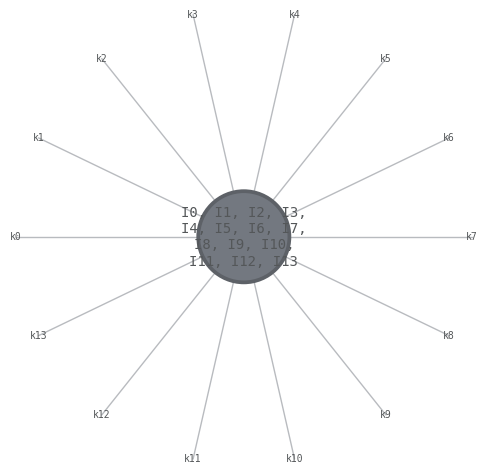

In [72]:
q1.draw()

In [73]:
bs = symmetry_actions[1]

In [74]:
symmetry_site_pairs = (
    [(i, bs[0]) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
    + [(i, bs[1]) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
)

In [75]:
problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites
)

AttributeError: 'list' object has no attribute 'inds'

In [76]:
leftmost_symmetry_site = left_most_symmetry_site

In [77]:
quimb_psi = q1

In [78]:
q_top = quimb_psi.copy(deep=True)
for i, s in symmetry_site_pairs:
    q_top.gate(
        s,
        where=i,
        contract=False,
        inplace=True
    )


indices_to_map = list(chain(
    range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
    range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
))

index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

q_bottom = (
    quimb_psi
    .copy()
    .reindex(index_mapping, inplace=True)
    .conj()
)

sites_to_contract = {
    'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
    'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
    'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
}

tags_to_contract = {
    k: [f'I{i}' for i in v]
    for k, v in sites_to_contract.items()
}

tn = (q_top & q_bottom)

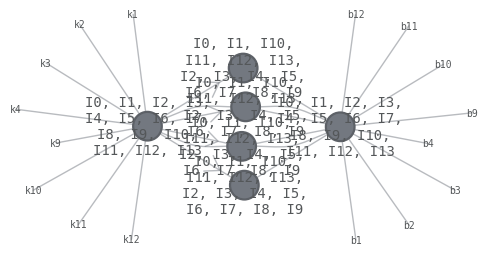

In [79]:
tn.draw()

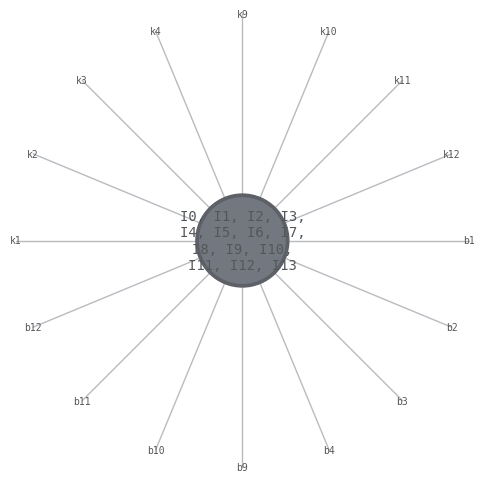

In [83]:
tn.contract().draw()

In [80]:
tnc1 = tn.contract(tags_to_contract['left'])

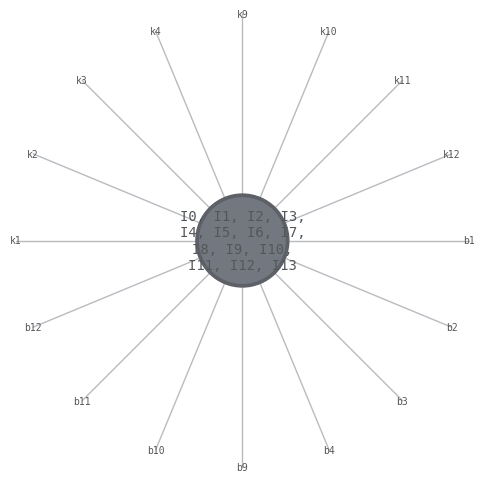

In [82]:
tnc1.draw()

In [81]:
sites_to_contract

{'left': [0], 'middle': [5, 6, 7, 8], 'right': [13]}

In [ ]:
tnc1.draw()